In [1]:
import cvxopt
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../pyutils')
import metrics
import utils

# Support Vector Classifier

[Support-Vector Networks - Cortes, Vapnik, 1995](http://image.diku.dk/imagecanon/material/cortes_vapnik95.pdf)

We have $N$ training points $(x_i, y_i)$ with $x_i \in \mathbb{R}^p$ and $y_i \in \{ -1, 1 \}$.

We can define an hyperplane as $\{x: x^T\beta + \beta_0 = 0 \}$.  
Separating hyperplane can be used to classify the data: $G(x) = \text{sign} (x^T\beta + \beta_0)$.
We are trying to find an hyperplane, parameterized by $\beta$ and $\beta_0$, that correctly separate the training data.  

This correspond to solving the following problem:
$$\min_{\beta, \beta_0} ||\beta||$$
$$\text{subject to } y_i(x_i^T\beta + \beta_0) \geq 1, i=1,\text{...},N$$

A solution only exists if the training is linearly separable.  

To handle the non separable clases, we may allow some points to be on the wrong side of the margin.  
Lets define some slack variables: $\zeta = (\zeta_1, \text{...}, \zeta_N)$.  
We modify the constraints as:
$$y_i(x_i^T\beta + \beta_0) \geq M(1 - \zeta_i)$$
$$\zeta_i \geq 0, \space \sum_{i=1}^N \zeta_i \leq \text{constant}$$
$\zeta_i$ is the proportional amount by wich prediction for $x_i$ is on the wrong side of the margin. Misclassification occurs when $\zeta_i > 1$.

The problem became:
$$\min_{\beta, \beta_0} ||\beta||$$
$$\text{subject to } y_i(x_i^T\beta + \beta_0) \geq 1 - \zeta_i, i=1,\text{...},N$$
$$\text{subject to } \zeta_i \geq 0, \space \sum_{i=1}^N \zeta_i \leq \text{constant}$$

The problem can be reformulated as:
$$\min_{\beta, \beta_0} \frac{1}{2} ||\beta||^2 + C \sum_{i=1}^N \zeta_i$$
$$\text{subject to } \zeta_i \geq 0, \space y_i(x_i^T\beta + \beta_0) \geq 1 - \zeta_i, i=1,\text{...},N$$

with $C$ the cost parameter, an hyperparameter. The hard margin case corresponds to $C = \infty$.  

We get the following Lagrange (primal) problem:

$$L_P(\beta, \beta_0, \zeta) = \frac{1}{2} ||\beta||^2 + C \sum_{i=1}^N \zeta_i - \sum_{i=1}^N \alpha_i [y_i(x_i^T\beta + \beta_0) - (1 - \zeta_i)] - \sum_{i=1}^N \mu_i \zeta_i$$

$$\min_{\beta, \beta_0, \zeta; \zeta_i \geq 0} \max_{\alpha, \mu ; \alpha_i \geq 0, \mu_i \geq 0} L_P(\beta, \beta_0, \zeta)$$

Instead of solving the primal, we solve the dual, that gaves the same result:

$$\min_{\beta, \beta_0, \zeta; \zeta_i \geq 0} \max_{\alpha, \mu ; \alpha_i \geq 0, \mu_i \geq 0} L_P(\beta, \beta_0, \alpha) = max_{\alpha, \mu ; \alpha_i \geq 0, \mu_i \geq 0} \min_{\beta, \beta_0, \zeta; \zeta_i \geq 0} L_P(\beta, \beta_0, \zeta)$$ 

We start by minimizing $L_P(\beta, \beta_0, \zeta)$ with respect to $\beta$, $\beta_0$, and $\zeta$.  

Solving $\frac{\partial L_P(\beta, \beta_0, \zeta)}{\partial \beta} = 0$, we get:
$$\beta = \sum_{i=1}^N \alpha_i y_i x_i$$
Solving $\frac{\partial L_P(\beta, \beta_0, \zeta)}{\partial \beta_0} = 0$, we get:
$$\sum_{i=1}^N \alpha_i y_i = 0$$
Solving $\frac{\partial L_P(\beta, \beta_0, \zeta)}{\partial \zeta} = 0$, we get:
$$\alpha_i = C - \mu_i, \space i=1,\text{...},N$$

Remplacing on the original equation, we get:

$$L_D(\alpha) = \sum_{i=1}^N\alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{k=1}^N \alpha_i \alpha_k y_i y_k x_i^Tx_k$$

The problem became:
$$\max_{\alpha} L_D(\alpha)$$
$$\text{s.t. } 0 \leq \alpha_i \leq C \space i=1,\text{...}, N$$
$$\text{s.t. } \sum_{i=1}^N \alpha_i y_i = 0$$

Another condition is satisfied:
    
$$\alpha_i[y_i(x_i^T\beta + \beta_0) - (1 - \zeta_i)] = 0 \space i = 1,\text{...},N$$

- $\alpha_i =0$:  $y_i(x_i^T + \beta_0) > (1 - \zeta_i)$
- $\alpha_i > 0$ and $\zeta_i = 0$: $y_i(x_i^T + \beta_0) = 1$, which means $x_i$ is on the boundary of the slab, and $0 < \alpha_i < C$
- $\alpha_i > 0$ and $\zeta_i > 0$: $\alpha_i = C$

$\beta$ is defined in terms of a linear combination of the support points $x_i$ (where $\alpha_i > 0$):

$$\beta = \sum_{i=1}^N \alpha_i y_i x_i$$

$\beta_0$ is obtained by solving $y_i(x_i^T + \beta_0) = 1$ for any support points with $\zeta_i = 0$.

Predictions are made using:
$$\hat{G}(x) = \text{sign}(x^T\hat{\beta} + \hat{\beta_0})$$

We now convert the problem into a standard quadradic programming problem:
    
Let $H \in \mathbb{R}^{N*N}$: $H_{ij} = y_i y_j x_i^Tx_j$

The problem became:
$$\max_{\alpha} 1^T\alpha - \frac{1}{2} \alpha^TH\alpha$$
$$\text{s.t. } \alpha_i \geq 0$$
$$\text{s.t. } \alpha_i \leq C$$
$$\text{s.t. } y^T \alpha = 0$$

We reverse the sign and turn it into a minimization:

$$\min_{\alpha} \frac{1}{2} \alpha^TH\alpha - 1^T\alpha$$
$$\text{s.t. } - \alpha_i \leq 0$$
$$\text{s.t. } \alpha_i \leq C$$
$$\text{s.t. } y^T \alpha = 0$$

We can compute the parameters:

$$\beta = (y \odot \alpha) X$$
$$\beta_0 = y_i - x_i \beta, \space \forall i: \alpha_i > 0 \text{ and } \zeta_i = 0$$

train acc: 0.7395833333333334
 test acc: 0.8082191780821918


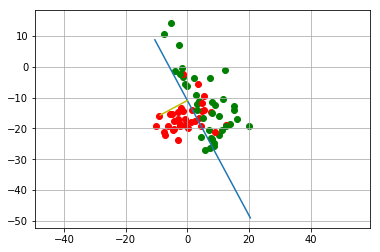

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.decomposition import PCA

def plot_data(b, b0, X, y):

    #bo + b1x1 + b2x2 = 0 => x2 = -b1/b2*x1 - b0/b2 
    x1 = np.linspace(np.min(X[:,0]) - .5, np.max(X[:,0]) + .5, 1000)
    plt.plot(x1, -b[0]/b[1]*x1 -b0/b[1])
    
    b10 = b / np.linalg.norm(b) * 10
    plt.plot([0, b10[0]], [-b0/b[1], b10[1]-b0/b[1]], c='y')
    
    for i in range(len(X)):
        plt.scatter(X[i][0], X[i][1], c=('r' if y[i] == 1 else 'g'))

    plt.axis('equal')
    plt.grid()
    plt.show()


X, y = load_digits().data, load_digits().target
X = PCA(n_components=2).fit_transform(X)

X = X[(y == 1) | (y == 7)]
y = y[(y == 1) | (y == 7)]

y[y == 1] = -1
y[y == 7] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                   random_state=15)


clf = SVC(C=1, kernel='linear')
clf.fit(X_train, y_train)

print('train acc:', np.mean(clf.predict(X_train) == y_train))
print(' test acc:', np.mean(clf.predict(X_test) == y_test))

plot_data(clf.coef_[0], clf.intercept_[0], X_test, y_test)

train acc: 0.7395833333333334
 test acc: 0.8082191780821918


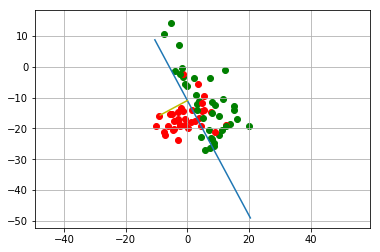

In [3]:
def svm_soft(X, y, C):
    n, p = X.shape
    X = X.astype(np.double)
    y = y.astype(np.double)
    
    H = (y.reshape(-1, 1)*X @ (y.reshape(-1, 1)*X).T)
    
    P = cvxopt.matrix(H)
    q = cvxopt.matrix(-np.ones((n, 1)))
    G = cvxopt.matrix(np.vstack((-np.eye(n),np.eye(n))))
    h = cvxopt.matrix(np.hstack((np.zeros((n,)), C*np.ones(n))))
    A = cvxopt.matrix(y.reshape(1, -1))
    b = cvxopt.matrix(np.zeros((1,)))
    
    cvxopt.solvers.options['show_progress'] = False
    cvxopt.solvers.options['abstol'] = 1e-10
    cvxopt.solvers.options['reltol'] = 1e-10
    cvxopt.solvers.options['feastol'] = 1e-10
    
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    alpha = np.array(sol['x']).flatten()
    
    beta = (y * alpha) @ X
    S = (alpha > 1e-4) & ((alpha - C)**2 > 1e-8)
    beta0 = y[S] - (X[S] @ beta)
    beta0 = np.mean(beta0)
    
    return alpha, beta, beta0
    
alpha, beta, beta0 = svm_soft(X_train, y_train, C=1)

tr_preds = np.sign(X_train @ beta + beta0)
te_preds = np.sign(X_test @ beta + beta0)
print('train acc:', np.mean(tr_preds == y_train))
print(' test acc:', np.mean(te_preds == y_test))
plot_data(beta, beta0, X_test, y_test)

In [4]:
S = (alpha > 1e-4)
S_idxs = np.arange(len(X_train))[S]
S_vecs = X_train[S_idxs]
S_nc = np.array([
    np.sum(y_train[S_idxs] == -1),
    np.sum(y_train[S_idxs] == +1),
])

y_pred = np.sign(X_train @ beta + beta0)
acc = np.average(y_train == y_pred)

print('beta:', beta)
print('beta_0:', beta0)
#print('Indices of support vectors:', S_idxs)
#print('Support vectors:', S_vecs)
print('Number of support vectors for each class:', S_nc)
print('Accuracy:', acc)

beta: [-0.17638236 -0.09457743]
beta_0: -1.0342950130536737
Number of support vectors for each class: [95 94]
Accuracy: 0.7395833333333334


In [5]:
#Comparing with sklearn

from sklearn.svm import SVC
clf = SVC(C = 1, kernel = 'linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
acc = np.average(y_train == y_pred)

print('beta:', clf.coef_)
print('beta_0:', clf.intercept_)
#print('Indices of support vectors:', clf.support_)
#print('Support vectors:', clf.support_vectors_)
print('Number of support vectors for each class:', clf.n_support_)
print('Accuracy:', acc)

beta: [[-0.17639468 -0.09456635]]
beta_0: [-1.03416889]
Number of support vectors for each class: [95 94]
Accuracy: 0.7395833333333334


# SVM and Kernels

We can apply basis expansions to the input features before using an SVM classifier:

$$h(x_i) = (h_1(x_i), h_2(x_i), \text{...}, h_M(x_i))$$

An extension of the SVM allows to use very large basis expansions, even infintie ones, at a cheap cost.  
For learning and inference, we only need to compute dot products between vectors of the input space. This can be done more cheaply than transforming the vectors on the new basis, and then computing their dot product.

The dual function to maximize is:

$$L_D(\alpha) = \sum_{i=1}^N\alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{k=1}^N \alpha_i \alpha_k y_i y_k \langle  h(x_i), h(x_k) \rangle$$

The prediction function can be written as:

$$f(x) = \sum_{i=1}^N \alpha_i y_i \langle h(x), h(x_i) \rangle + \beta_
0$$  

We only need to know the kernel function:

$$K(x,x') = \langle h(x), h(x') \rangle$$

Popular choices of kernel are:

- The $d$-th degree polynomial:
$$K(x, x') = (1 + \langle x, x' \rangle )^d$$

- The radial basis function (RBF):
$$K(x, x') = \exp (- \gamma ||x - x'||^2)$$

- Neural network:
$$K(x, x') = \tanh(k_1 \langle x, x' \rangle + k_2)$$

In [6]:
class SVMClassifier:
    
    def __init__(self, C, k, alpha_tol=1e-4):
        self.C = C
        self.k = k
        self.alpha_tol=alpha_tol
    
    def fit(self, X, y):
        
        n, p = X.shape
        X = X.astype(np.double)
        y = y.astype(np.double)
    
        H = np.empty((len(X), len(X)))
        for i in range(len(X)):
            for j in range(len(X)):
                H[i,j] = y[i] * y[j] * self.k(X[i], X[j])
        
        P = cvxopt.matrix(H)
        q = cvxopt.matrix(-np.ones((n, 1)))
        G = cvxopt.matrix(np.vstack((-np.eye(n),np.eye(n))))
        h = cvxopt.matrix(np.hstack((np.zeros((n,)), self.C*np.ones(n))))
        A = cvxopt.matrix(y.reshape(1, -1))
        b = cvxopt.matrix(np.zeros((1,)))

        cvxopt.solvers.options['show_progress'] = False
        cvxopt.solvers.options['abstol'] = 1e-10
        cvxopt.solvers.options['reltol'] = 1e-10
        cvxopt.solvers.options['feastol'] = 1e-10

        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        alpha = np.array(sol['x']).flatten()

        beta = (y * alpha) @ X
        S = (alpha > self.alpha_tol) & ((alpha - self.C)**2 > 1e-6)
        
        beta0 = np.empty(len(y[S]))
        for j in range(len(beta0)):
            beta0[j] = y[S][j]
            for i in range(len(X)):
                beta0[j] -= alpha[i] * y[i] * self.k(X[S][j], X[i])
        beta0 = np.mean(beta0)
        
        self.alpha = alpha
        self.beta0 = beta0
        self.X = X
        self.y = y
        
    def predict(self, X):
        y = np.empty(len(X))
        for i in range(len(X)):
            y[i] = self.get_pred(X[i])
        return y
        
    def get_pred(self, x):
        y = self.beta0
        for i in range(len(self.X)):
            y += self.alpha[i] * self.y[i] * self.k(x, self.X[i])
        return np.sign(y)
    
def kernel_linear():
    return lambda x, y: x @ y

def kernel_poly(d):
    return lambda x, y: (1 + x @ y) ** d

def kernel_rbf(gamma):
    return lambda x, y: np.exp(-gamma * (x - y)@(x - y))

## Linear kernel

$$K(x, x') = \langle x, x' \rangle$$
$$h(x) = x$$

In [7]:
clf = SVMClassifier(C=2, k=kernel_linear())
clf.fit(X, y)

S = (clf.alpha > 1e-4)
S_idxs = np.arange(len(X))[S]
S_nc = np.array([
    np.sum(y[S_idxs] == -1),
    np.sum(y[S_idxs] == +1),
])
acc = np.average(clf.predict(X) == y)

print('beta_0:', clf.beta0)
print('Number of support vectors for each class:', S_nc)
print('Accuracy:', acc)

beta_0: -1.1035094245422812
Number of support vectors for each class: [113 113]
Accuracy: 0.7534626038781164


In [8]:
#Comparing with sklearn

from sklearn.svm import SVC
clf = SVC(C=2, kernel='linear')
clf.fit(X, y)
acc = np.average(clf.predict(X) == y)

print('beta_0:', clf.intercept_[0])
print('Number of support vectors for each class:', clf.n_support_)
print('Accuracy:', acc)

beta_0: -1.1032004588267146
Number of support vectors for each class: [113 113]
Accuracy: 0.7534626038781164


## Polynomial Kernel

$$K(x, x') = (1 + \langle x, x' \rangle)^d$$

$h(x)$ perform a polynomial expansion of degree $d$. For a vector $x \in \mathbb{R}^p$, we get a feature space of size:
$$\binom{p+d}{d}$$

When $d = 2$:

$$h(x) = (1, \sqrt{2} x_1, \text{...}, \sqrt{2} x_p,  x_1^2, \text{...}, x_p^2, \sqrt{2} x_p x_{p-1}, \text{...}, \sqrt{2} x_p x_1, \sqrt{2} x_{p-1} x_{p-2}, \sqrt{2} x_{p-1} x_1, \text{...}, \sqrt{2} x_2 x_1)$$

When $d=2, p=3, x=(x_1, x_2, x_3)$:
$$h(x) = (1, \sqrt{2} x_1, \sqrt{2} x_2, \sqrt{2} x_3, x_1^2, x_2^2, x_3^2, \sqrt{2} x_3 x_2, \sqrt{2} x_3 x_1, \sqrt{2} x_2 x_1)$$

In [9]:
clf = SVMClassifier(C=2, k=kernel_poly(3), alpha_tol=1e-8)
clf.fit(X, y)

S = (clf.alpha > clf.alpha_tol)
S_idxs = np.arange(len(X))[S]
S_nc = np.array([
    np.sum(y[S_idxs] == -1),
    np.sum(y[S_idxs] == +1),
])
acc = np.average(clf.predict(X) == y)

print('beta_0:', clf.beta0)
print('Number of support vectors for each class:', S_nc)
print('Accuracy:', acc)

beta_0: -2.5554429279229227
Number of support vectors for each class: [66 64]
Accuracy: 0.853185595567867


In [10]:
#Comparing with sklearn

from sklearn.svm import SVC
clf = SVC(C=2, kernel='poly', degree=3, gamma=1.0, coef0=1.0)
clf.fit(X, y)
acc = np.average(clf.predict(X) == y)

print('beta_0:', clf.intercept_[0])
print('Number of support vectors for each class:', clf.n_support_)
print('Accuracy:', acc)

beta_0: -32.02557396710759
Number of support vectors for each class: [45 42]
Accuracy: 0.8254847645429363


## RBF Kernel

$$K(x, x') = \exp (- \frac{||x - x'||^2}{2\sigma^2})$$ 
We often use the $\gamma$ parameter instead:
$$\gamma = \frac{1}{2 \sigma^2}$$

The feature space of $h(x)$ has an infite number of dimensions.  

The RBF function acts as a similarity measure. The closer are $x$ and $x'$, the higher is the value, and the more far, the lower is the value. When the distance is $\infty$ the value is $0$, and when $x=x'$ the value is 1.

The $\gamma$ parameter defines how far the influence of a single training exmample reaches, with low values meaning far, and high value meaning closes.  
With $\gamma$ too large, the area of influence of a support vector only includes the support vector itself, and the model is prone to huge overfitting.  
With $\gamma$ too small, the area of influence of a support vector includes the whole training set, and the model converges to a linear one.

In [11]:
clf = SVMClassifier(C=2, k=kernel_rbf(1.5))
clf.fit(X, y)

S = (clf.alpha > clf.alpha_tol)
S_idxs = np.arange(len(X))[S]
S_nc = np.array([
    np.sum(y[S_idxs] == -1),
    np.sum(y[S_idxs] == +1),
])
acc = np.average(clf.predict(X) == y)

print('beta_0:', clf.beta0)
print('Number of support vectors for each class:', S_nc)
print('Accuracy:', acc)

beta_0: -0.14826393600246957
Number of support vectors for each class: [162 157]
Accuracy: 0.9695290858725761


In [12]:
#Comparing with sklearn

from sklearn.svm import SVC
clf = SVC(C=2, kernel='rbf', gamma=1.5)
clf.fit(X, y)
acc = np.average(clf.predict(X) == y)

print('beta_0:', clf.intercept_[0])
print('Number of support vectors for each class:', clf.n_support_)
print('Accuracy:', acc)

beta_0: -0.14827271768510564
Number of support vectors for each class: [162 157]
Accuracy: 0.9695290858725761


## SVM as a Penalization mthod

The SVM problem is:

$$\min_{\beta, \beta_0} \frac{1}{2} ||\beta||^2 + C \sum_{i=1}^N \zeta_i$$
$$\text{subject to } \zeta_i \geq 0, \space y_i(x_i^T\beta + \beta_0) \geq 1 - \zeta_i, i=1,\text{...},N$$

This is equivalent to the following problem:

$$\min_{\beta_0, \beta} \sum_{i=1}^N (1 - y_if(x_i))_+ + \frac{\lambda}{2} ||\beta||^2$$

with $\lambda = \frac{1}{C}$

This is based on the hingle loss function:
$$L(y,f) = (1 - yf)_+ = \max(0, 1 - yf)$$

This formulation shrinks the weights $\beta$ toward $0$. It also helps to see that $C$ act as a regularization parameter.  
Lower values of $C$ gives more shrinkage, and regularize the model. Higher values gives more complex models, that may overfit

## SVM Path algorithm

In order to chose the $C$ hyperparameter, one solution is to train several SVM with different values of $C$, in order to evaluate, compare and choose the best one.  
The Path algorithm is an algorithm to fit the entiere sequence of SVM more efficiently.

The solution for $\beta$ is given by:
$$\beta_\lambda = \frac{1}{\lambda} \sum_{i=1}^N \alpha_i y_i x_i$$

At the initialisation, we start with a huge value of $\lambda$, giving huge margins, with all points on the training set inside them, with $\alpha_i = 1$.  
We slowly decrease $\lambda$, several training points move from inside to outside the margin, setting $\alpha_i = 0$.

## SVM for Regression

[Support Vector Regression Machines](https://papers.nips.cc/paper/1238-support-vector-regression-machines.pdf)

The linear model is:
$$f(x) = x^T \beta + \beta_0$$

We minimise the following criterion:
$$H(\beta_0, \beta) = \sum_{i=1}^N V(y_i - f(x_i)) + \frac{\lambda}{2} ||\beta||^2$$

with the error measure $V_\epsilon$:
$$
V_\epsilon(r) = 
\begin{cases}
    0 & \text{if } |r| < \epsilon \\
    |r| - \epsilon & \text{otherwise}
\end{cases}
$$

This is an $\epsilon$-sensitive mesure, ignores errors less than $\epsilon$.  
Points in the training set that are close to the model prediction have an error of $0$, and are ignored by the model.  
This is an analogy to the SVM, where points correctly classified and outisde the margins ($\alpha_i = 0$) are ignored by the model.  

The solution has the form:
$$\hat{\beta} = \sum_{i=1}^N (\hat{\alpha}^*_i - \hat{\alpha}_i) x_i$$
$$\hat{f}(x) = \sum_{i=1}^N (\hat{\alpha}^*_i - \hat{\alpha}_i) \langle x,x_i \rangle + \beta_0$$

$\hat{\alpha}_i$ and $\hat{\alpha}^*_i$ are found by solving the following quadratic problem:
$$\min_{\alpha_i, \alpha^*_i} \epsilon \sum_{i=1}^N (\alpha^*_i + \alpha_i) - \sum_{i=1}^N y_i(\alpha^*_i - \alpha_i) + \frac{1}{2} \sum_{i,i'=1}^N (\alpha^*_i - \alpha_i) (\alpha^*_{i'} - \alpha_{i'}) \langle x_i, x_{i'} \rangle$$
$$\text{s.t. } 0 \leq \alpha_i, \space \alpha^*_i \leq 1/\lambda$$
$$\text{s.t. } \sum_{i=1}^N (\alpha^*_i - \alpha_i) = 0$$
$$\text{s.t. } \alpha^*_i \alpha_i = 0$$

The support vectors are the training points such that$(\alpha^*_i - \alpha_i)$ is not null. The model output only depends of those.  
As for classification, the input values are only used through the inner product $\langle x, x_i \rangle$, so the the Kernel trick can also be applied.

# Generalizing Linear Discriminant Analysis

LDA is a simple and low variance classifier that produces linear decision boundaries.  
Several ideas can be applied to generalize this model to non-linear cases:
- FDA: cast LDA as regression, and do it into an enlarged space, as for SVM kernels
- PDA: penalize its coefficients
- MDA: model each class by a mixture of Gaussians

# Flexible Discriminant Analysis

[Flexible Discriminant Analysis by Optimal Scoring - Hastie, Tibshirani, 2000](https://www.researchgate.net/publication/2889611_Flexible_Discriminant_Analysis_by_Optimal_Scoring)

We use the fact that LDA is equivalent to canonical correlation analysis, it gives solution to a problem that we describe.  

Suppose $\theta: \mathcal{G} \to \mathbb{R}$ assign scores to the classes such that the transformed class labels are optimally predicted by linear regression on $X$.  
We can find $K$ set of independents scoring $\theta_k$ and corresponding linear map: $\mu_k(X) = X^T\beta_k$.  

$\theta_k$ and $\beta_k$ are chosen to minimize:
$$\text{ASR} = \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^N (\theta_k(g_i) - x^T_i\beta_k)^2$$

The scores are assumed to be mutually orthogonal and normalized to avoid trivial zero solutions.  
The sequence of LDA vectors $u_k$ is identical to the sequence $\beta_k$ up to a constant.  

Let $Y \in \mathbb{R}^{N*J}$ the indicator matrix corresponding to the dummy-variable coding for the classes.  
Let $\Theta \in \mathbb{R}^{J*K}$ the score matrix, such that $\Theta_{jk} = \theta_k(j)$  
Let $\Theta^* \in \mathbb{R}^{N*K}$ the matrix of transformed values of the classes: $\Theta^* = Y\Theta$.  

If the scores were fixed, we would just have to regress $\Theta^*$ on $X$ to minimize ASR.  

Let $P_X$ the projection matrix such that $\hat{Y} = P_XY$, with $\hat{Y}$ the predictions of the model.

$$\text{ASR}(\theta) = \frac{1}{N} \text{tr} (\Theta^TY^T (I - P_X)Y\theta )$$  

In order to minimize ASR, find the optimal scoring $\Theta$ amounts to find the eigenvectors of $Y^TP_XY$. This can be done without computing $P_X$.  

LDA optimal scoring algorithm:

1. Initialize the indicator matrix $Y$
2. Find the coefficients matrix $B \in \mathbb{R}^{p*J}$ by regressing $Y$ on $X$, and set $\hat{Y} = XB$
3. Obtain the eigenvector matrix $\theta$ of $Y^T\hat{Y} = Y^TP_XY$
4. Obtain the final weights matrix: $B \in \mathbb{R}^{p*K}: B \leftarrow B \theta$, with $\beta_k = B_{:,k}$

The model can be extended to non-linear cases: we replace the linear projection operator $P_X$ by any non-linear regression procedure $S(\lambda)$.

FDA optimal scoring algorithm:
1. Choose an initial score matrix $\Theta_0$ satisfying the constraints $\Theta^T D_P \Theta - I$
2. Set $\Theta^*_0 = Y\Theta_0$
3. Fit a regression model of $\Theta_0^*$ on $X$, giving us $S(\hat{\lambda})$ and $\mu(x)$ the vector of fitted regression functions.
4. Get fitted valus $\hat{\Theta}^*_0$
5. Obtain the eigenvector matrix $\Phi$ of $\Theta^{*T}_0  \hat{\Theta}^*_0 = \Theta^*_0S(\hat{\lambda})\Theta_0^*$
6. Get optimal scores: $\Theta = \Theta_0 \Phi$
7. Update final model from step 3 using the optimal scores

# Penalized Discriminant Analysis

[Penalized Discriminant Analysis - Hastie, Tibshirani, Buja, 2000](https://www.researchgate.net/publication/2923857_Penalized_Discriminant_Analysis)

FDA can be seen as a regualized form of LDA. Suppose we perform a linear regression into a basis expansions $h(X)$, adding a quadratic penalty on the coefficients:

$$\text{ASR} = \frac{1}{N} \sum_{l=1}^L  \left[ \sum_{i=1}^N (\theta_l(g_i) - h^T(x_i)\beta_l)^2 + \lambda \beta_l^T \Omega \beta_l \right]$$ 

$\Omega$ depends on the problem, it might constrait $h(x)\beta_l$ to be smooth for example.

PDA algorithm:
1. Enlarge $X$ via basis expansion $h(X)$
2. Use penalized LDA on the enlarged space. The penalized Mahalbonis distance is:
    $$D(x, \mu) = (h(x) - h(\mu))^T (\Sigma_W + \lambda \Omega)^{-1} (h(x) - h(\mu))$$
    with $\Sigma_W$ the within-class covariance matrix of $h(x_i)$
3. Solve the penalized LDA problem:
    $$\max u^T \Sigma_B u$$
    $$\text{s.t. } u^T(\Sigma_W + \lambda \Omega)u = 1$$

# Mixture Discriminant Analysis

[Discriminant Analysis by Gaussian Mixtures - Hastie, Tibshirani, 1996](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.10.3633)

A Gausssian mixture model for $k$-th class has density:
$$P(X|G=k) = \sum_{r=1}^{R_k} \pi_{kr} \phi(X;\mu_{kr},\Sigma)$$

The $k$-th class has $K$ Gaussian, each with it's one mean $\mu_{kr}$ and mixing proportion $\pi_{kr}$. All Gaussians share the same covariance matrix $\Sigma$.

The posterior probabilities are given by:
$$p(G=k|X=x) = \frac{\sum_{r=1}^{R_k} \pi_{kr} \phi(X;\mu_{kr},\Sigma) \Pi_k }{\sum_{l=1}^K \sum_{r=1}^{R_l} \pi_{lr} \phi(X;\mu_{lr},\Sigma) \Pi_l}$$

with $\Pi_k$ the prior probability of class $k$.  

The parameters are estimated with maximum likelihood of $P(G,X)$ on the training data:
$$\sum_{k=1}^K \sum_{g_i=k} \log \left[ \sum_{r=1}^{R_k} \pi_{kr} \phi(x_i;\mu_{kr},\Sigma) \Pi_k \right]$$

The model is fitted with the EM algorithm:

- E-step: Compute the responsability of subclasses $c_{kr}$ for each class-$k$ observations. It indicates how much each observations is close to the centroid of every Gaussian for it's class $k$.
- M-step: Perform MLE using weights from the E-step.  
    This step turns out to be a weighted version of LDA. Furthermore, we can use FDA or PDA instead.